# TP1-G2. Filtrado lineal óptimo

**Integrantes:**
- BAUTISTA SCHNEEBERGER
- SANTIAGO EZEQUIEL MANGONE
- SERGIO ANDRES PERALTA


### Bibliotecas usadas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fft
from IPython.display import Audio
from scipy.io import wavfile
import os
from scipy import linalg

In [2]:
import matplotlib as mpl
font_name = "Times New Roman"
mpl.rcParams['font.family'] = font_name

# 1) a) b) c) d) e) f)
## Lectura y creación de archivos .wav

Para poder realizar una correcta sincronización a cada audio se lo formatió de la siguiente manera:

**2 segundos de ceros - 1 segundo de un tono 800Hz - 2 segundos de ceros - 10 segundos de la señal de interés**

Resulta de interés para este informe visualizar la diferencia entre el el uso del tono de 800Hz y una delta. Se analizará más adelante.


In [3]:
fs = 48000
f0 = 20
f1 = 20000
T = 10
p = np.arange(0, fs*1)
tone_sinchronization = np.sin(2*np.pi*800*p/fs)

# Barrido lineal
k = (f1 - f0)/T
n = np.arange(0, fs*T)
barrido_lineal = np.sin(2*np.pi*f0*n/fs + 2*np.pi*k*(n/fs)**(2) / 2 )
wavfile.write('barrido_lineal.wav', fs, np.concatenate((np.zeros(2*fs), tone_sinchronization, np.zeros(2*fs), barrido_lineal)))

# Barrido exponencial
k = (f1/f0)**(1/T)
barrido_exponencial = np.sin(2*np.pi*f0*(k**(n/fs) - 1)/np.log(k))
wavfile.write('barrido_exponencial.wav', fs, np.concatenate((np.zeros(2*fs), tone_sinchronization, np.zeros(2*fs), barrido_exponencial)))

# Ruido blanco gaussiano
WGN = np.random.normal(size=int(T*fs))
WGN = WGN/np.max(WGN)
wavfile.write('WGN.wav', fs, np.concatenate((np.zeros(2*fs), tone_sinchronization, np.zeros(2*fs), WGN)))

# Señal rectangular 100Hz
fsqr = 100
t = np.linspace(0, T, int(T*fs), endpoint=False)
square_wave = 0.5 * (1 + np.sign(np.sin(2 * np.pi * fsqr * t))) * 2 - 1
wavfile.write("senial_rec.wav", fs, np.concatenate((np.zeros(2*fs), tone_sinchronization, np.zeros(2*fs), square_wave)))

# Señal de música 
_, musica = wavfile.read('musica_raw.wav')
wavfile.write("musica.wav", fs, np.concatenate((np.zeros(2*fs), tone_sinchronization, np.zeros(2*fs), musica/32767))) 

# Señal de voz 
_, people_talking = wavfile.read('people_talking_raw.wav')
wavfile.write("people_talking.wav", fs, np.concatenate((np.zeros(2*fs), tone_sinchronization, np.zeros(2*fs), people_talking/32767))) 

In [4]:
class Audio:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.MSE = []
        self.Jo = []
        self.wo = []


itter = [['senial_de_voz', 'people_talking.wav', 'people_talking_y.wav', 11.665],
         ['senial_de_musica', 'musica.wav', 'musica_y.wav', 12.156],
         ['senial_rec', 'senial_rec.wav', 'senial_rec_y.wav', 13.213],
         ['barrido_lineal', 'barrido_lineal.wav', 'barrido_lineal_y.wav', 6.104],
         ['barrido_exponencial', 'barrido_exponencial.wav', 'barrido_exponencial_Y.wav', 8.98],
         ['WGN', 'WGN.wav', 'WGN_y.wav', 9.046]]

# Armamamos un diccionario con las distintas señales
aud = {name[0] : Audio(wavfile.read(name[1])[1], wavfile.read(name[2])[1] / np.max(wavfile.read(name[2])[1])) for name in itter} 


***signal_conditioning(x, y, time_shift)*** : permite sincronizar la señal grabada con señal de entrada a partir de un *time_shift* que se especifica a partir de la inspección de la señal.

In [5]:
def signal_conditioning(x, y, time_shift):
    y = y[int(time_shift*fs) + int(3*fs):int(time_shift*fs) + int(3*fs) + int(10*fs)]
    x = x[int(5*fs):]
    return x, y

In [6]:
# Aplico el condicionamiento de señal a todas las señales
for (key, value) , name in zip(aud.items(), itter):
    time_shift = name[3]
    aud[key].x, aud[key].y = signal_conditioning(value.x, value.y, time_shift)

In [7]:
x = aud['barrido_exponencial'].x
y = aud['barrido_exponencial'].y

wavfile.write('TST_X.wav', fs, x)
wavfile.write('TST_Y.wav', fs, y)

## Espectro de potencia de las distintas señales de entrada

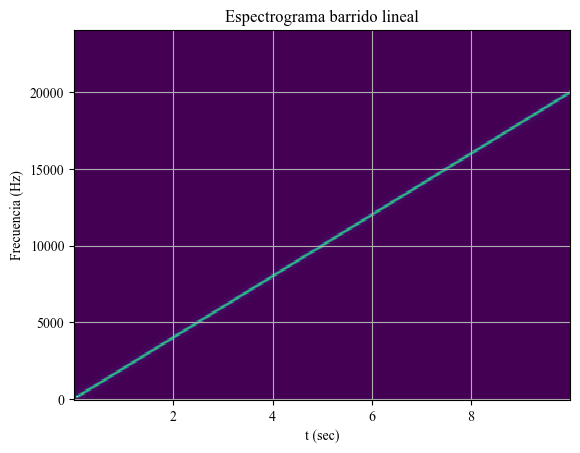

In [8]:
ff, tt, Sxx = signal.spectrogram(aud['barrido_lineal'].x, fs=fs, nperseg=256, nfft=576)
plt.figure()
plt.pcolormesh(tt, ff, Sxx)
plt.title('Espectrograma barrido lineal')
plt.xlabel('t (sec)')
plt.ylabel('Frecuencia (Hz)')
plt.grid(True)

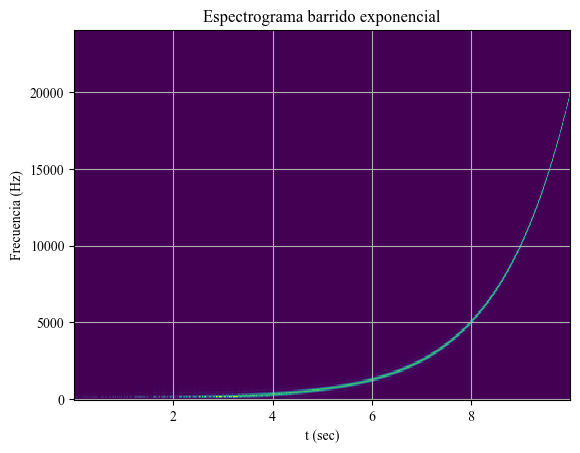

In [9]:
ff, tt, Sxx = signal.spectrogram(aud['barrido_exponencial'].x, fs=fs, nperseg=256, nfft=576)
plt.figure()
plt.pcolormesh(tt, ff, Sxx)
plt.title('Espectrograma barrido exponencial')
plt.xlabel('t (sec)')
plt.ylabel('Frecuencia (Hz)')
plt.grid(True)

Por inspección de los dos espectrogramas anteriores. Se puede notar como el barrido exponencial distribuye su energía mucho más en las bajas frecuencias. Si bien el espectro audible va de $20\text{Hz}$ a $20000\text{Hz}$, la distribución no es constante. Las energía suele concentrarse en bajas y medianas frecuencias

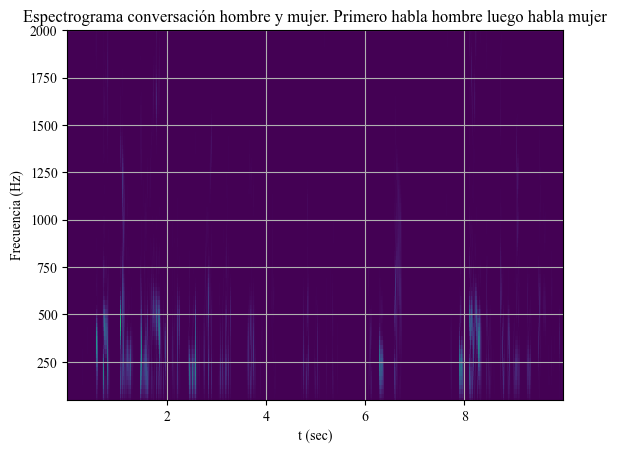

In [10]:
ff, tt, Sxx = signal.spectrogram(aud['senial_de_voz'].x, fs=fs, nperseg=256, nfft=2048)
plt.figure()
plt.pcolormesh(tt, ff, Sxx)
plt.title('Espectrograma conversación hombre y mujer. Primero habla hombre luego habla mujer')
plt.xlabel('t (sec)')
plt.ylabel('Frecuencia (Hz)')
plt.ylim(50, 2000)
plt.grid(True)

La señal de voz, es la grabación de una hombre y una mujer hablando. Primero el hombre y luego la mujer. De esta forma se buscó tener un mayor span de frecuencia, debido a que el hombre suele tener un espectro más grave.

De todas formas, no se puede observar lo comentado anteriormente, pareciera incluso que la voz masculina tiene mas componentes de alta frecuencia.

La canción, de reggaeton, porque tiene muchos instrumentos y efectos sonando de fondo. Lo cual implica  

---
# Implementación del filtro óptimo

In [11]:
# x: señal de entrada al sistema (parlante)
# y: señal mensurada en el micrófono
# Deben ser del mismo tamaño
def get_params(x, y, M):
    N = len(x)
    r = signal.correlate(x, x, method = 'fft')
    r = r[N-1:N-1 + M] # Me quedo con los las positivos, es par ... 
    p = signal.correlate(x, y, method = 'fft') 
    p = np.flip(p[N-1 - (M-1) :N]) # Me quedo con los negativos y flipeo asi el primer elemento se corresponde a lag 0
    return r, p
def optimal_linear_filter(x, y, M):
    r, p = get_params(x, y, M)
    wo = linalg.solve_toeplitz(r, p)
    Jo = np.mean(y**2) - np.dot(p/len(x), wo)
    MSE_normalizado = Jo/np.mean(y**2)
    return wo, Jo, MSE_normalizado
def simulate_system(x, wo):
    y_hat = signal.lfilter(wo, [1], x)
    return y_hat

**Detalle menor para el informe pero que se tuvo que tener en cuenta**:

Scipy implementa la correlación de la siguiente manera:

*signal.correlate(...)* :
$$
z[k]=(x*y)(k-N+1)=\sum_{l=0}^{||x||-1}x_{l}y_{l-k+N-1}^{*}
$$

Por lo tanto, resulta de interés conocer el vector de cross correlation dado por:
$$
    \bold{p} = [x(n) y^*(n), \;x(n-1) y^*(n),\; ..., \;x(n-M+1) y^*(n)]^T
$$

Serán de interés los lags de la correlación que son $\leq 0$ 

Por eso en *get_params(x, y, M)* se toman los lags negativos para $\bold{p}$

---
# 2) ¿Cuál de las excitaciones creen que dará la mejor estimación de $h(n)$?

En base a los distintos espectros de potencia, se estima que el WGN debe lograr la mejor estimación de $h(n)$, porque logra estimular todos las frecuencias del espectro. Es cierto que el barrido exponencial puede lograr un buen ajuste fundamentalmente para las frecuencias de interés, pero creemos que WGN debe estimar mejor la $h(n)$. Un modelo MA(270) mostró que el uso WGN resultaba en una estimación sin bias de los coeficientes reales, mientras los barridos resultaban teniendo un bias. Esto no intenta ser ningún tipo de demostración rigurosa, son solo observaciones hechas.   

# 3) Valor de $M$ óptimo para el barrido lineal. $J_o(M)$. 

**¿Cómo pueden reducir el cálculo necesario?**

Con el uso del algortmo Levinson-Durbin. Que explota las características de la matriz de autocorrelación logrando un complejidad $\mathcal{O}(n^2)$, en lugar de $\mathcal{O}(n^3)$ que es lo que cuesta la inversión de una matriz.

# $J_o(M)$

In [12]:
M_values = [int(0.001*fs), int(0.005*fs),int(0.01*fs), int(0.05*fs), int(0.1*fs), int(0.2*fs),
              int(0.3*fs), int(0.4*fs), int(0.5*fs),
            int(0.6*fs), int(0.7*fs), int(1*fs),
            int(1.2*fs), int(1.5*fs)] 

xm = aud['barrido_lineal'].x
ym = aud['barrido_lineal'].y
aud['barrido_lineal'].Jo = []
for m in M_values:
    wo, J, MSE_normalizado = optimal_linear_filter(xm, ym, m)
    aud['barrido_lineal'].Jo.append(J) 

' for key in aud:\n    xm = aud[key].x - np.mean(aud[key].x)\n    ym = aud[key].y - np.mean(aud[key].y)\n    aud[key].MSE = []\n    for m in M_values:\n        wo, J, MSE_normalizado = optimal_linear_filter(xm, ym, m)\n        aud[key].MSE.append(MSE_normalizado) '

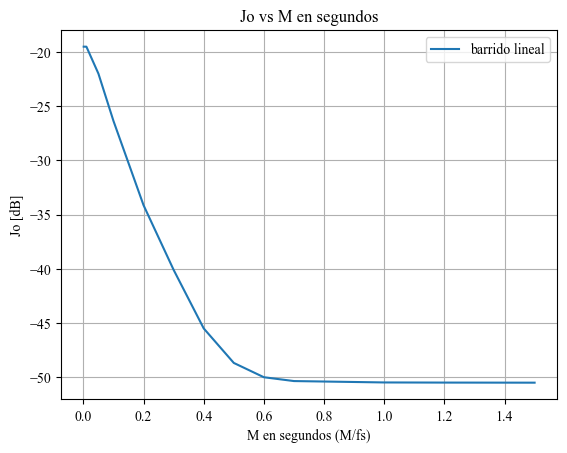

In [14]:
plt.figure()
plt.title('Jo vs M en segundos')
plt.plot(np.array(M_values)/fs, 10*np.log10(aud['barrido_lineal'].Jo), label = 'barrido lineal')
plt.xlabel('M en segundos (M/fs)')
plt.ylabel('Jo [dB]')
plt.grid()
plt.legend()
plt.show()

Se elije $M = 0.8\cdot fs$ como valor óptimo, porque visualmente se puede ver que el $Jo$ deja de bajar, podría darse el caso de que se esté en un plateu, pero dado que incluso para $M = 1.4\cdot fs$ el $Jo$ se mantiene constante, se elije $M = 0.8\cdot fs$ para no tener redundancia.

Ahora estimamos el ruido de fondo usando un segmento de la grabación en silencio ambiente:

In [15]:
# Ruido de fondo 
bckground_noise = wavfile.read('barrido_lineal_y.wav')[1]/np.max(wavfile.read('barrido_lineal_y.wav')[1])
bckground_noise = bckground_noise[int(7.8*fs):int(8.6*fs)]
sigma_2_noise = np.std(bckground_noise)**2
print('Ruido de fondo en dB:', 10*np.log10(sigma_2_noise))

Ruido de fondo en dB: -75.63979121330124


Dando $-75\text{dB}$, lo cual implica que no se logró un modelo que ajusta perfecto a la acústica del baño, dado que se podría haber seguido bajando. Esto no quiere decir que hay que seguir agrandando el $M$, porque este desajuste se puede deber a haber modelado a la acústica como un modelo MA, las alinealidades no fueron modeladas.

# 4) Estimación de $h(n)$, $\hat{H}(e^{j\omega})$ con el M elegido para las grabaciones

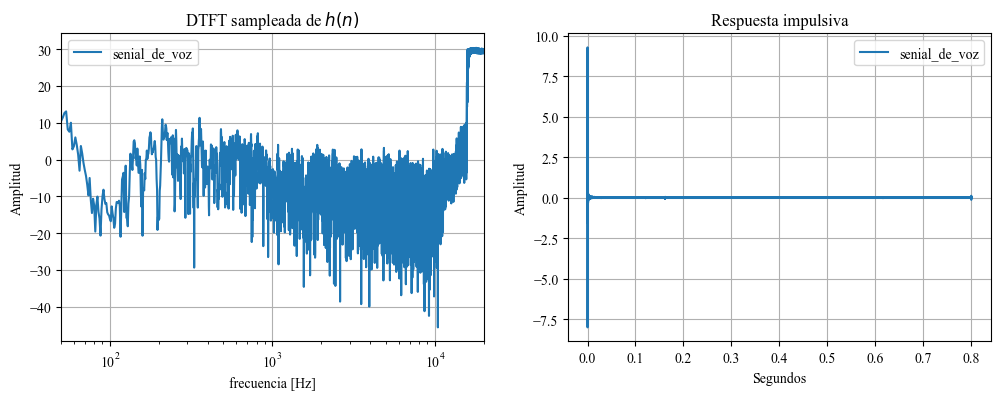

<Figure size 640x480 with 0 Axes>

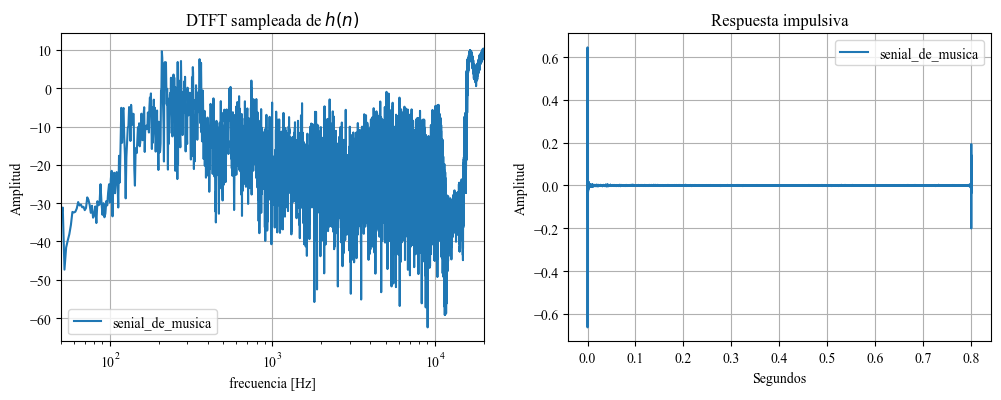

<Figure size 640x480 with 0 Axes>

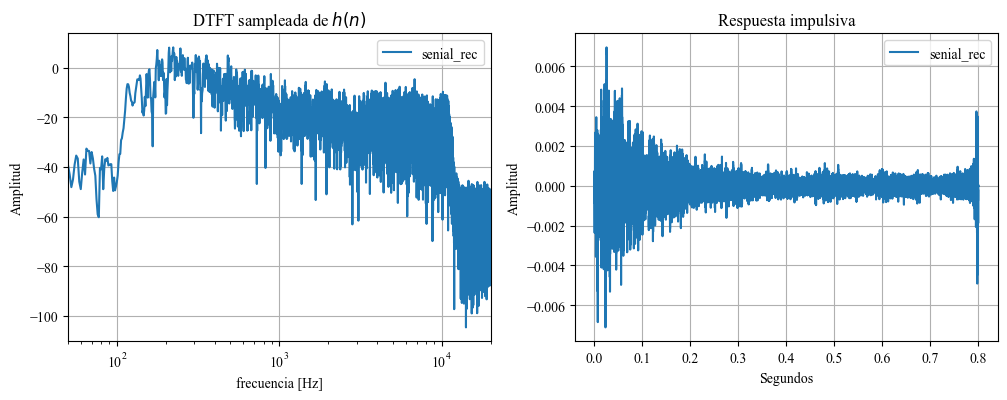

<Figure size 640x480 with 0 Axes>

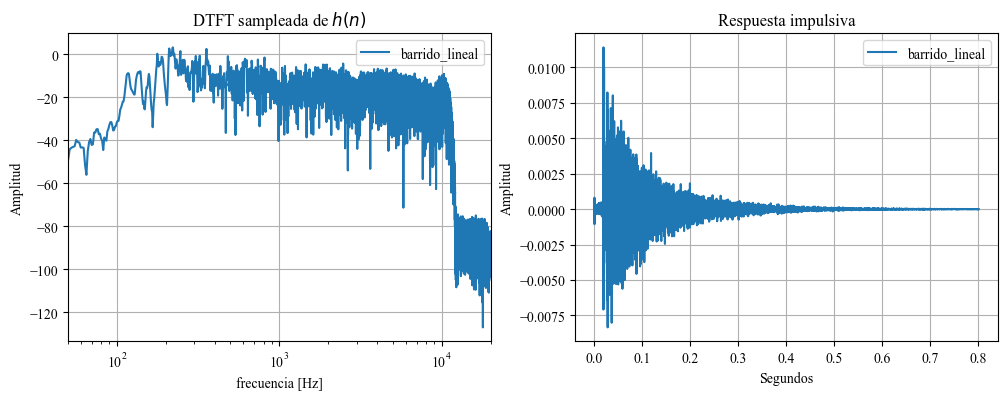

<Figure size 640x480 with 0 Axes>

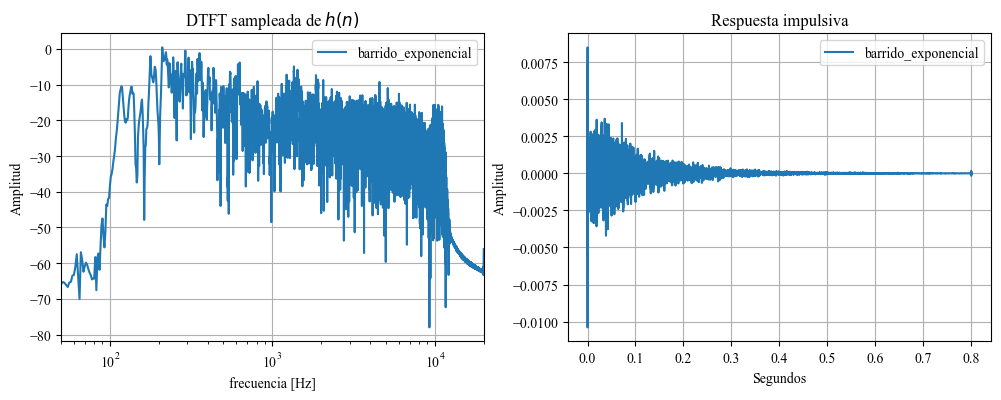

<Figure size 640x480 with 0 Axes>

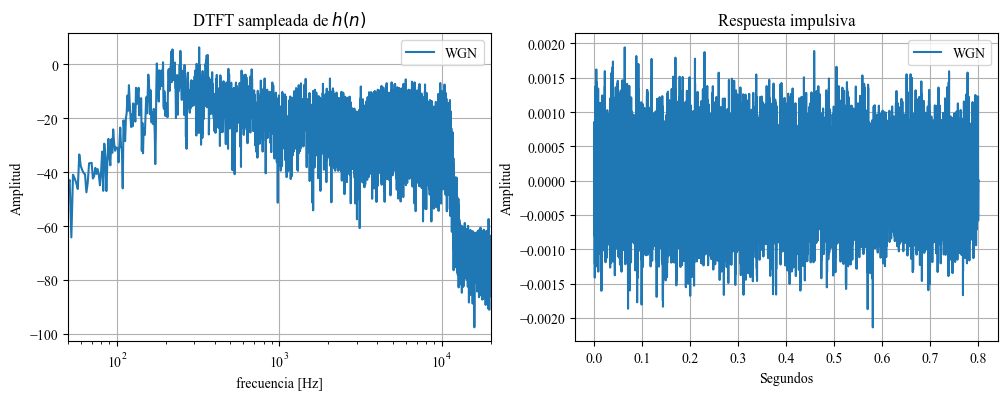

<Figure size 640x480 with 0 Axes>

In [19]:
M_optimo = int(0.8*fs)
for key in aud:
    xm = aud[key].x 
    ym = aud[key].y
    wo, J, MSE_normalizado = optimal_linear_filter(xm, ym, M_optimo)
    aud[key].MSE = MSE_normalizado
    H = fft.fftshift(fft.fft(wo))
    frqs = fft.fftshift(fft.fftfreq(len(H), d = 1/fs))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    plt.figure()
    axes[0].set_title('DTFT sampleada de $h(n)$')
    axes[0].plot(frqs, 20*np.log10(np.abs(H)), label = key)
    axes[0].set_xlabel('frecuencia [Hz]')
    axes[0].set_ylabel('Amplitud')
    axes[0].set_xlim(50, 20000)
    axes[0].set_xscale('log')
    axes[0].legend()
    axes[0].grid()
    axes[1].set_title('Respuesta impulsiva')
    delta = np.zeros(len(wo)+50)
    delta[0] = 1
    impulsive_response = signal.lfilter(wo, [1], delta)
    n = np.arange(0, len(impulsive_response))/fs
    axes[1].plot(n, impulsive_response, label = key)
    axes[1].set_xlabel('Segundos')
    axes[1].set_ylabel('Amplitud')
    axes[1].legend()
    axes[1].grid()
    plt.show()

Es importante aclarar que para la estimación de $\hat{H}(e^{j\omega})$ no se usó ningún tipo de ventana. Esto es porque dado que la respuesta impulsiva de un FIR se anula para $n<0$ y para $n>M-1$, la FFT será un sampleo de la DTFT de la $h(n)$.

De las respuestas impulsivas anteriores, se puede notar que quienes más se condicen con la respuesta impulsiva típica de una habitación, son las del barrido exponencial y barrido lineal. La señal de voz y señal de música, son muy similares, mientras que WGN exhibe amplitudes relativamente altas a tiempos tardíos. Esto se puede entender de la siguiente forma. Dado que el WGN tiene su energía repartida en todas las bandas, la $h(n)$ intentará copiar ese comportamiento en todo el espectro mientras que las señales de música excitan MENOS componentes espectrales, por lo tanto su modelo será menos complejo. 

### MSE de las grabaciones

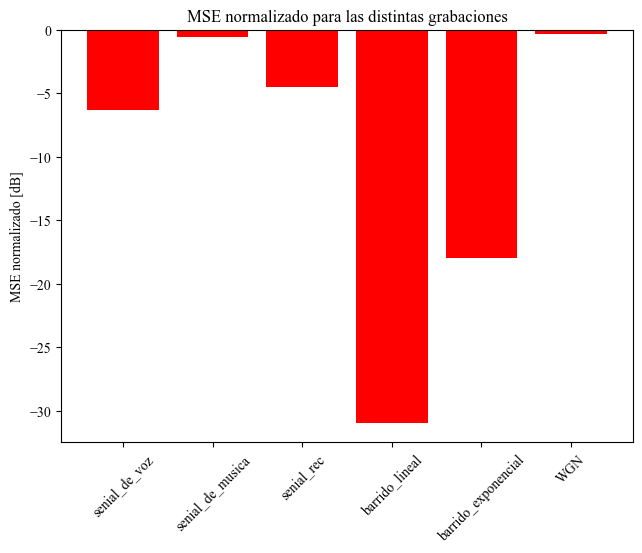

In [27]:
MSE = []
cat = []
for key in aud:
    MSE.append(10*np.log10(aud[key].MSE))
    cat.append(key)
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel('MSE normalizado [dB]')
plt.title('MSE normalizado para las distintas grabaciones')
plt.bar(cat, MSE, color='r')
plt.show()

---
# 5) Comparación con punto 2

Con estos resultados notamos que WGN fue el que peor performó, distinto a lo pensado. El barrido lineal logró imponerse al barrido exponencial, lo cual es curioso porque el exponencial piensa ser una mejora respecto al lineal a la hora de estimación del modelo MA para una habitación.  

# Veamos quien estima mejor la $h(n)$

In [28]:
for key in aud:
    aud[key].wo, _, _ = optimal_linear_filter(aud[key].x, aud[key].y, int(0.4*fs))
    fs, speech_file = wavfile.read('musica.wav')
    speech_file = speech_file[int(5*fs):]
    z = signal.fftconvolve(speech_file, aud[key].wo, mode='full', axes=None) 
    wavfile.write(f'{key}_FILTERED.wav', fs,  (z / np.max(z) * 32767).astype(np.int16))

Se comprueba entonces que el **barrido lineal** y **barrido exponencial** son lo que logran mejores resultados perceptivos. No se notan diferencia entre ellos para la canción utilizada. 

# LO QUE SIGUE AHORA HAY QUE TIRARLO

# Test con un sistema conocido

0.07230727092675499


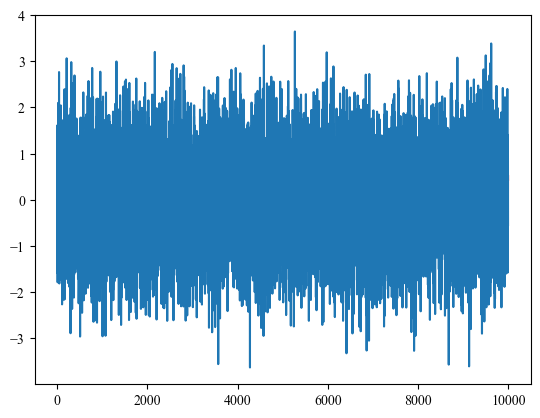

In [17]:
b = [1/5, 3, 1/5, 1/5, 1, 3, 2, 1, 1] * 200
b = np.array(b)*0.01
x = np.random.normal(size = 10000) 
n = np.arange(0, int(fs*10))

y = signal.lfilter(b, [1], x)
plt.plot(y, color = 'r')
plt.plot(x)
M = int(len(b)/5)
wo, J, _ = optimal_linear_filter(x, y, M)
print(np.std(y)**2)

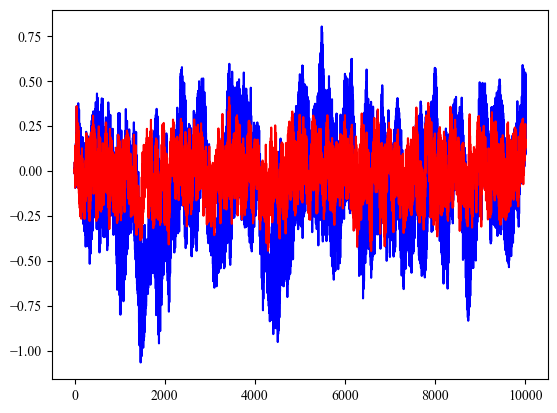

In [18]:
y_hat = signal.lfilter(wo, [1], x)
#y_hat = signal.fftconvolve(x, wo, mode='full')
plt.plot(y, color = 'b')
plt.plot(y_hat, color = 'r')
plt.show()

In [19]:
def plot_Jo(x, y, label_str, M = 10):
    M_values = np.arange(1, M, 10)
    MSE = []
    xm = x - np.mean(x)
    ym = y - np.mean(y)
    for m in M_values:
        wo, J, MSE_normalizado = optimal_linear_filter(xm, ym, m)
        MSE.append(MSE_normalizado)

    plt.plot(M_values, MSE, label = label_str)


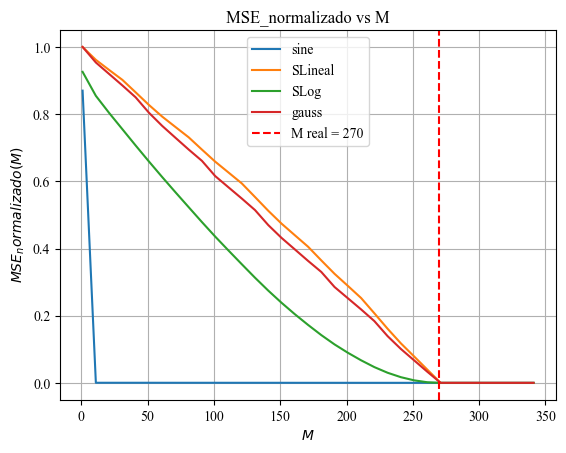

In [20]:
fs = 48000
f0 = 20
f1 = 20000
T = 10

# Senoidal cruda 10 segundos
n = np.arange(0, fs*T)
x = np.sin(2*np.pi*1e3*n/fs)
y = signal.lfilter(b, [1], x)
plot_Jo(x, y, 'sine', M = int(len(b)*1.3))

# Sweep lineal 10 seg
k = (f1 - f0)/T
n = np.arange(0, fs*T)
x = np.sin(2*np.pi*f0*n/fs + 2*np.pi*k*(n/fs)**(2) / 2 )
y = signal.lfilter(b, [1], x)
plot_Jo(x, y, 'SLineal',M = int(len(b)*1.3))

# Sweep logaritmico 10 seg
k = (f1/f0)**(1/T)
n = np.arange(0, fs*T)
x = np.sin(2*np.pi*f0*(k**(n/fs) - 1)/np.log(k))
y = signal.lfilter(b, [1], x)
plot_Jo(x, y, 'SLog',M = int(len(b)*1.3))

# Ruido gaussiano incorrelacionado
x = np.random.normal(size = int(fs*10)) 
y = signal.lfilter(b, [1], x)
plot_Jo(x, y,'gauss', M = int(len(b)*1.3))


plt.axvline(x=len(b), color='r', linestyle='--', label=f'M real = {len(b)}')

plt.title('MSE_normalizado vs M')
plt.xlabel('$M$')
plt.ylabel('$MSE_normalizado(M)$')
plt.grid(True)
plt.legend()
plt.show()

# Generalización

In [24]:
FIR_coeff = np.exp(b)
T = 50
print('@ M = M_real, muestro MSE entre los coeff reales y los estimados: ')
# Senoidal cruda 10 segundos
n = np.arange(0, fs*T)
x = np.sin(2*np.pi*10e3*n/fs)
y = signal.lfilter(b, [1], x)
wo, J, MSE = optimal_linear_filter(x, y, M = len(FIR_coeff))
print('SEN STD = ', np.std((FIR_coeff - wo)))

# Sweep lineal 10 seg
k = (f1 - f0)/T
n = np.arange(0, fs*T)
x = np.sin(2*np.pi*f0*n/fs + 2*np.pi*k*(n/fs)**(2) / 2 )
y = signal.lfilter(b, [1], x)
wo, J, MSE = optimal_linear_filter(x, y, M = len(FIR_coeff))
print('SLineal STD = ', np.std((FIR_coeff - wo)))

 # Sweep logaritmico 10 seg
k = (f1/f0)**(1/T)
n = np.arange(0, fs*T)
x = np.sin(2*np.pi*f0*(k**(n/fs) - 1)/np.log(k))
y = signal.lfilter(b, [1], x)
wo, J, MSE = optimal_linear_filter(x, y, M = len(FIR_coeff))
print('SLog STD = ', np.std((FIR_coeff - wo)))

# Ruido gaussiano incorrelacionado
x = np.random.normal(size = int(fs*T)) 
y = signal.lfilter(b, [1], x)
wo, J, MSE = optimal_linear_filter(x, y, M = len(FIR_coeff))
print('Gauss STD = ', np.std((FIR_coeff - wo)))

@ M = M_real, muestro MSE entre los coeff reales y los estimados: 
SEN STD =  0.00650906644017643
SLineal STD =  0.005100286481883641
SLog STD =  0.005196860282750738
Gauss STD =  1.0459257451897766e-06


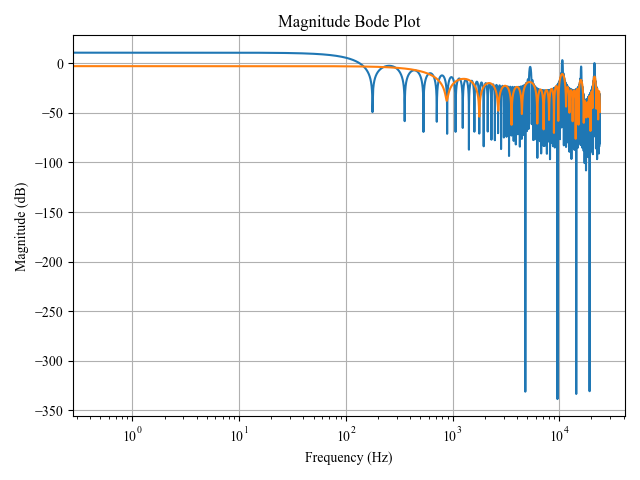

In [21]:
from scipy.signal import freqz

# Sampling frequency and number of points for the frequency response
fs = 48000  # Hz
num_points = 50000

# Compute the frequency response
frequencies, response = freqz(b, 1, worN=num_points, fs=fs)


magnitude = 20 * np.log10(np.abs(response))
phase = np.angle(response, deg=True)


# Compute the frequency response
frequencies2, response2 = freqz(wo, 1, worN=num_points, fs=fs)


magnitude2 = 20 * np.log10(np.abs(response2))


%matplotlib ipympl
# Plot magnitude response
plt.close()
plt.figure()
plt.semilogx(frequencies, magnitude)
plt.semilogx(frequencies2, magnitude2)
plt.title('Magnitude Bode Plot')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid()

plt.tight_layout()
plt.show()


# Prueba de generalizacion para Slog con ruido blanco gaussiano

In [22]:
# Sweep logaritmico 10 seg
k = (f1/f0)**(1/T)
n = np.arange(0, fs*T)
x = np.sin(2*np.pi*f0*(k**(n/fs) - 1)/np.log(k))
y = signal.lfilter(b, [1], x)
wo, J, MSE = optimal_linear_filter(x, y, M = len(FIR_coeff))

x_gener = np.random.normal(size = 10000)
y_hat_1 = signal.lfilter(wo, [1], x_gener)

n = np.arange(0, fs*T)
x = np.sin(2*np.pi*1e3*n/fs)
y = signal.lfilter(b, [1], x)
wo, J, MSE = optimal_linear_filter(x, y, M = len(FIR_coeff))
y_hat_2 = signal.lfilter(wo, [1], x_gener)

y = signal.lfilter(b, [1], x_gener)
plt.figure()
plt.plot(y, color = 'b')
plt.plot(y_hat_1, color = 'r')
#plt.plot(y_hat_2, color = 'g')
plt.title('Generalización de wo estimados a WN')
plt.show()

NameError: name 'FIR_coeff' is not defined

## **Con la senoidal funciona mal**